## Dataset: Carvana Image Masking Challenge

In our first experiment today, we will use a famous dataset for image segmentation, which is called Carvana (https://www.kaggle.com/competitions/carvana-image-masking-challenge/overview). We need to download it:

* Login with you kaggle account on https://www.kaggle.com/ .
* Go to the link of the challenge and subscribe to the rules of the challenge.
* In Account, press Create New API Token. This will download a file named $\texttt{kaggle.json}$. Upload this file on Colab.
* Run the following.

In [5]:
# Install Kaggle library
!pip install kaggle

# Create a new folder .kaggle and move kaggle.json into that
!mkdir ~/.kaggle
!mv kaggle.json ~/.kaggle/

# Allocate permissions for this file
!chmod 600 ~/.kaggle/kaggle.json

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [6]:
# Download the data from the competition. If an error occours, either you did
# something wrong on the above or you forgot to subscribe the challenge.
!kaggle competitions download -c carvana-image-masking-challenge

100% 24.4G/24.4G [03:39<00:00, 85.6MB/s]
100% 24.4G/24.4G [03:39<00:00, 120MB/s] 


In [7]:
# The dataset is huge. For our experiments today, we just need a subset of it.
# Unzip train.zip and the corresponding masks. Not the HQ version.
!unzip -p carvana-image-masking-challenge.zip train.zip >train.zip
!unzip -p carvana-image-masking-challenge.zip train_masks.zip >train_masks.zip

# Unzip the zipped train files.
!unzip train.zip
!unzip train_masks.zip

Output streaming troncato alle ultime 5000 righe.
  inflating: train_masks/0789bed99cb8_09_mask.gif  
 extracting: train_masks/0789bed99cb8_10_mask.gif  
 extracting: train_masks/0789bed99cb8_11_mask.gif  
 extracting: train_masks/0789bed99cb8_12_mask.gif  
  inflating: train_masks/0789bed99cb8_13_mask.gif  
  inflating: train_masks/0789bed99cb8_14_mask.gif  
  inflating: train_masks/0789bed99cb8_15_mask.gif  
  inflating: train_masks/0789bed99cb8_16_mask.gif  
 extracting: train_masks/0795e132d090_01_mask.gif  
 extracting: train_masks/0795e132d090_02_mask.gif  
 extracting: train_masks/0795e132d090_03_mask.gif  
 extracting: train_masks/0795e132d090_04_mask.gif  
 extracting: train_masks/0795e132d090_05_mask.gif  
 extracting: train_masks/0795e132d090_06_mask.gif  
 extracting: train_masks/0795e132d090_07_mask.gif  
 extracting: train_masks/0795e132d090_08_mask.gif  
 extracting: train_masks/0795e132d090_09_mask.gif  
 extracting: train_masks/0795e132d090_10_mask.gif  
 extracting: t

In [8]:
# Utilities
import os
from glob import glob

# Algebra
import numpy as np

# Visualization
import matplotlib.pyplot as plt
from PIL import Image
import cv2

# Neural Networks
import tensorflow as tf
from tensorflow import keras as ks

(1280, 1918, 3)


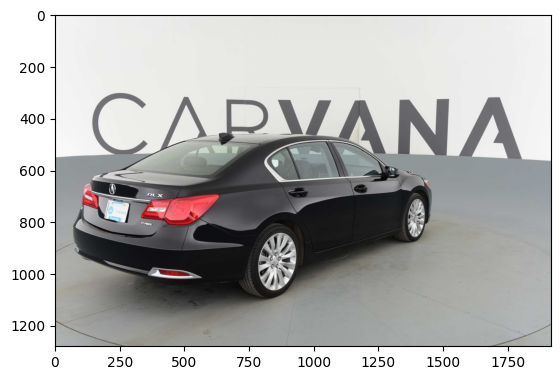

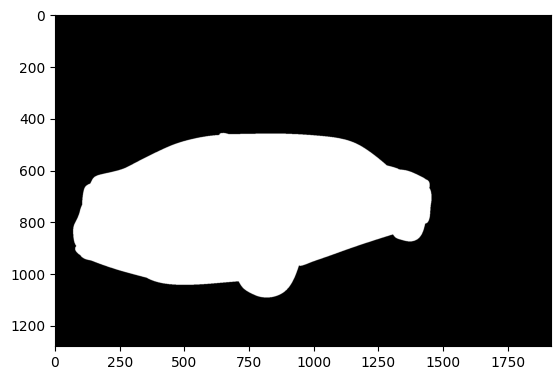

In [9]:
train_list=sorted(os.listdir("./train")) #save the names of all training files in the python list train_list
mask_list=sorted(os.listdir("./train_masks"))  #save the names of all training MASKS files in the python list train_list
img=plt.imread(f"./train/{train_list[10]}")
img_mask=plt.imread(f"./train_masks/{mask_list[10]}")
print(img.shape)
plt.imshow(img)
plt.show()
plt.imshow(img_mask)
plt.show()

# Prepare dataset

In [10]:
def load_data_from_names(root_dir: str, fnames: list, shape=(256, 256)) -> np.array: #
    # Given the root path and a list of file names as input, return the dataset 
    # array.
    images = []
    
    for idx, img_name in enumerate(fnames):
        x = Image.open(os.path.join(root_dir, img_name))
        x = x.resize(shape)
        x = np.array(x)
        images.append(x)

        if idx%100 == 99:
            print(f"Processed {idx+1} images.")
    return np.array(images)

# Load the names
image_names = os.listdir('./train')
mask_names = os.listdir('./train_masks')
#sort
image_names.sort()
mask_names.sort()

# To reduce the computational time, we consider only a SUBSET of the dataset
N = 2000 # Number of total datapoints

image_names = image_names[:N]
mask_names = mask_names[:N]

# Create data. We will always use the notation that "x" is the input of the 
# network, "y" is the output.
x = load_data_from_names('./train', image_names)
y = load_data_from_names('./train_masks', mask_names)

# Print the dimension of the dataset.
print(f"The dimension of the dataset is: {x.shape}")

Processed 100 images.
Processed 200 images.
Processed 300 images.
Processed 400 images.
Processed 500 images.
Processed 600 images.
Processed 700 images.
Processed 800 images.
Processed 900 images.
Processed 1000 images.
Processed 1100 images.
Processed 1200 images.
Processed 1300 images.
Processed 1400 images.
Processed 1500 images.
Processed 1600 images.
Processed 1700 images.
Processed 1800 images.
Processed 1900 images.
Processed 2000 images.
Processed 100 images.
Processed 200 images.
Processed 300 images.
Processed 400 images.
Processed 500 images.
Processed 600 images.
Processed 700 images.
Processed 800 images.
Processed 900 images.
Processed 1000 images.
Processed 1100 images.
Processed 1200 images.
Processed 1300 images.
Processed 1400 images.
Processed 1500 images.
Processed 1600 images.
Processed 1700 images.
Processed 1800 images.
Processed 1900 images.
Processed 2000 images.
The dimension of the dataset is: (2000, 256, 256, 3)


## split train and test

In [11]:
N_train = 1800

x_train = x[:N_train]
y_train = y[:N_train]

x_test = x[N_train:]
y_test = y[N_train:]
print("SHAPES:")
print("TRAIN:",x_train.shape, y_train.shape)
print("TEST:",x_test.shape, y_test.shape)

SHAPES:
TRAIN: (1800, 256, 256, 3) (1800, 256, 256)
TEST: (200, 256, 256, 3) (200, 256, 256)


# Create CNN

In [12]:
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate
from tensorflow.keras import Model

In [ ]:
 def build_cnn(input_shape, n_ch, L=3): #L is number of layers
  x=Input(shape=input_shape) #first input layer
  h= x
  #convolution layers (L)
  for l in range(L):
    h = Conv2D(n_ch, 3, 1, padding="same", activation="relu")(h) #same n_ch channels forall layers, kernel_size of 3, stride of 1. Relu activaiton for the hidden layers
  # last classification layer
  y=Conv2D(1,1,1, padding="same", activation="sigmoid")(h) #last layer is still Conv2D (FULLY CONVOLUTIONAL!). Activation is SIGMOID since it's a BINARY CLASSIFICATION
  return Model(x,y)

CNN_model=build_cnn((256,256,3), 64, L=3)
CNN_model.compile(optimizer=ks.optimizers.Adam(learning_rate=1e-4),
                  loss="binary_crossentropy",
                  metrics=["accuracy"])
print(CNN_model.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 256, 256, 64)      1792      
                                                                 
 conv2d_1 (Conv2D)           (None, 256, 256, 64)      36928     
                                                                 
 conv2d_2 (Conv2D)           (None, 256, 256, 64)      36928     
                                                                 
 conv2d_3 (Conv2D)           (None, 256, 256, 1)       65        
                                                                 
Total params: 75,713
Trainable params: 75,713
Non-trainable params: 0
_________________________________________________________________
None


# U-NET

In [19]:
def build_unet(input_shape, n_ch=32, L=4, conv_per_L=2):
  #L=num of floors,
  #conv_per_L = num of conv layers in each floor

  #INPUT
  x=Input(shape=input_shape) #first input layer
  h=x

  #DOWN
  backup_layers=[]
  for l in range(L):
    for c in range(conv_per_L):
      h = Conv2D(n_ch, 3, 1, padding="same", activation="relu")(h) #conv
    if l<L-1:
      backup_layers.append(h) #save layer for the SKIPS (BEFORE DOWNSAMPLING!!!)
      h= MaxPooling2D(padding="same")(h)
      n_ch=n_ch*2 #double channels


  #UP
  for l in range(L-1):
    n_ch=n_ch//2 #divide channels
    h=UpSampling2D()(h)#upsample
    h = ks.layers.concatenate([h, backup_layers.pop(-1)])

    for c in range(conv_per_L):
      h = Conv2D(n_ch, 3, 1, padding="same", activation="relu")(h) #conv

  #OUTPUT
  y=Conv2D(1,1, activation="sigmoid")(h) #last layer is still Conv2D (FULLY CONVOLUTIONAL!). Activation is SIGMOID since it's a BINARY CLASSIFICATION
  return Model(x,y)


In [20]:
#compile
unet=build_unet((256,256,3))
unet.compile(optimizer=ks.optimizers.Adam(learning_rate=1e-4),
                  loss="binary_crossentropy",
                  metrics=["accuracy"])
print(unet.summary())

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_28 (Conv2D)             (None, 256, 256, 32  896         ['input_4[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_29 (Conv2D)             (None, 256, 256, 32  9248        ['conv2d_28[0][0]']              
                                )                                                             

## Training U-NET

In [21]:
# Training
BATCH_SIZE = 16
N_EPOCHS = 20

hist = unet.fit(x_train, y_train,
              batch_size=BATCH_SIZE,
              epochs=N_EPOCHS,
              validation_split=0.1)


Epoch 1/20
102/102 [==============================] - 58s 325ms/step - loss: 0.4356 - accuracy: 0.8748 - val_loss: 0.1377 - val_accuracy: 0.9470
Epoch 2/20
102/102 [==============================] - 29s 287ms/step - loss: 0.1062 - accuracy: 0.9603 - val_loss: 0.1268 - val_accuracy: 0.9520
Epoch 3/20
102/102 [==============================] - 29s 284ms/step - loss: 0.0607 - accuracy: 0.9773 - val_loss: 0.0817 - val_accuracy: 0.9700
Epoch 4/20
102/102 [==============================] - 29s 286ms/step - loss: 0.0470 - accuracy: 0.9823 - val_loss: 0.0486 - val_accuracy: 0.9823
Epoch 5/20
102/102 [==============================] - 29s 282ms/step - loss: 0.0318 - accuracy: 0.9880 - val_loss: 0.0399 - val_accuracy: 0.9853
Epoch 6/20
102/102 [==============================] - 29s 282ms/step - loss: 0.0252 - accuracy: 0.9904 - val_loss: 0.0312 - val_accuracy: 0.9881
Epoch 7/20
102/102 [==============================] - 29s 284ms/step - loss: 0.0224 - accuracy: 0.9914 - val_loss: 0.0284 - val_ac

In [24]:
unet.save_weights('segmentation_unet_train.h5')

In [26]:
def show(x, y, title=None):
    plt.figure(figsize=(15, 8))

    plt.subplot(1, 2, 1)
    plt.imshow(x)
    if title:
        plt.title(title[0])
    
    plt.subplot(1, 2, 2)
    plt.imshow(y)
    if title:
        plt.title(title[1])

    plt.show()



1/1 [==============================] - 0s 23ms/step


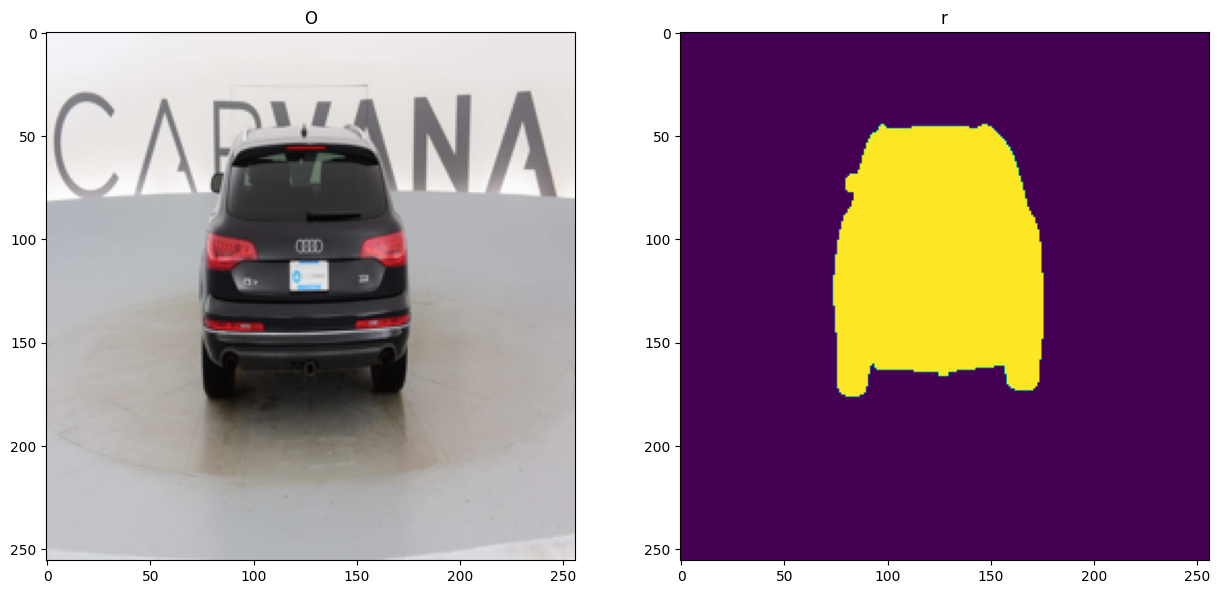

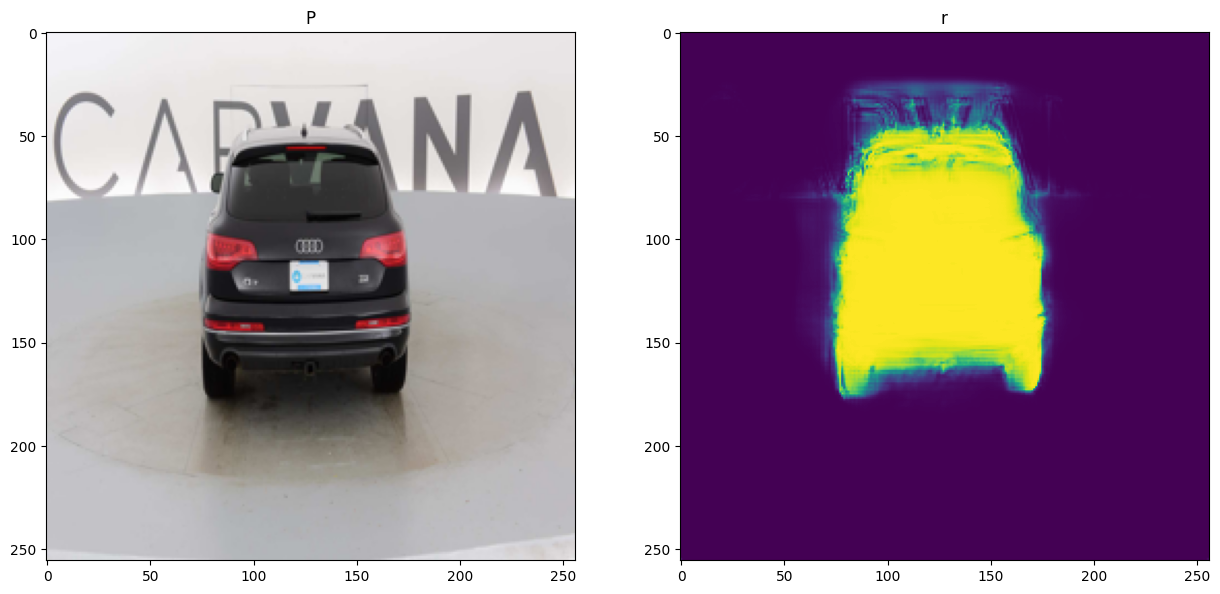

In [27]:
# Qualitative results
y_pred = unet.predict(x_test[:1])

show(x_test[0, :, :], y_test[0, :, :], title='Original')
show(x_test[0, :, :], y_pred[0, :, :, 0], title='Predicted')

# IoU and Dice metrics
Accuracy turns out to not be so good for measuriong the quality of segmentation models. IoU and Dice are much better

In [30]:
from keras import backend as K
from keras.losses import binary_crossentropy

def iou_coeff(y_true, y_pred):
    smooth = 1

    intersection = K.sum(K.abs(y_true * y_pred), axis=[1,2,3])
    union = K.sum(y_true,[1,2,3]) + K.sum(y_pred,[1,2,3]) - intersection

    iou = K.mean((intersection + smooth) / (union + smooth), axis=0)
    return iou

def dice_coeff(y_true, y_pred):
    smooth = 1

    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    score = (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return score

# Function that evaluate the model on a dataset
def evaluate_model(model, x, y, fun):
    y_pred = model.predict(x) # Use the model to predict the output
    y = np.expand_dims(y, -1) # We need to add the channel dimension on y

    # Uniform the type of the array
    y_pred = y_pred.astype('float32')
    y = y.astype('float32')

    return fun(y, y_pred)




In [32]:
iou = evaluate_model(unet, x_test,  y_test, iou_coeff)
dice = evaluate_model(unet, x_test,  y_test, dice_coeff)

print(f"The IoU of the trained model is {iou}, while its Dice coefficient is {dice}.")

7/7 [==============================] - 1s 131ms/step
The IoU of the trained model is 0.842924952507019, while its Dice coefficient is 0.916715681552887.
